<a href="https://colab.research.google.com/github/marcochow1026/LA_Crime_Time_Series/blob/main/LA_Crime_Time_Series_Analysis_trim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier

violent_crimes = pd.read_csv('/content/violent_crimes.csv')
violent_crimes['DATE OCC'] = pd.to_datetime(violent_crimes['DATE OCC'])
violent_crimes['year_month'] = violent_crimes['DATE OCC'].dt.to_period('M')

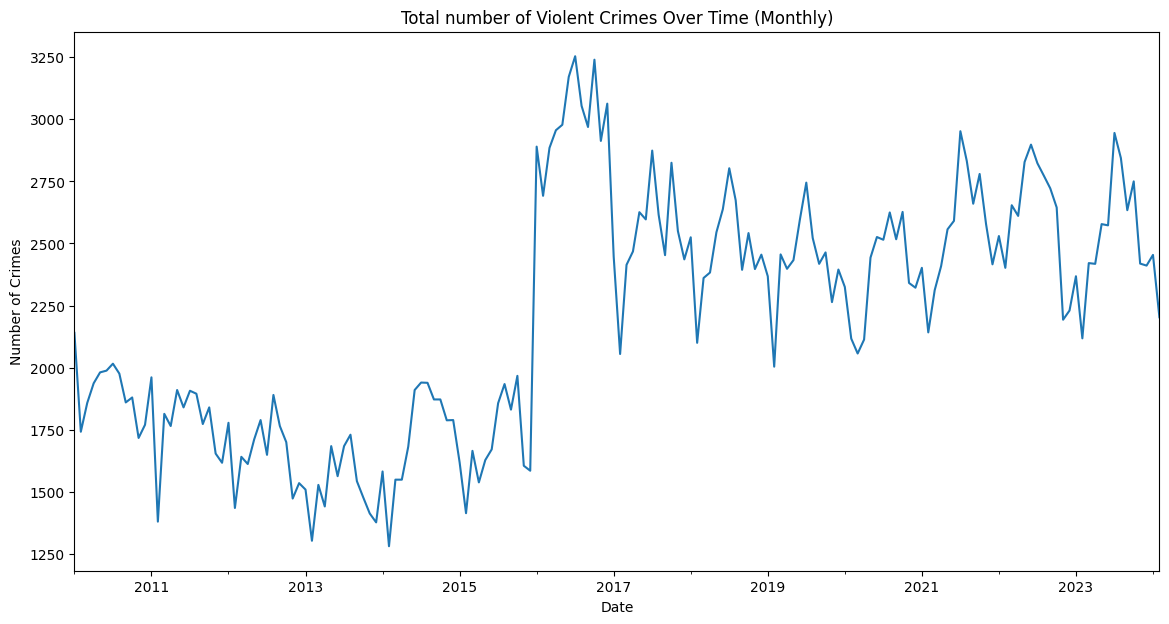

In [27]:
# Group by YearMonth and count occurrences
crime_counts_over_time = violent_crimes['year_month'].value_counts().sort_index()

# Plot the time series
plt.figure(figsize=(14, 7))
crime_counts_over_time.plot()
plt.title('Total number of Violent Crimes Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.show()

In [28]:
# Group by YearMonth and count occurrences
crime_counts_over_time = violent_crimes['year_month'].value_counts().sort_index()

# Convert Period → first day of the month (datetime)
crime_counts_df = crime_counts_over_time.to_frame(name='count')
crime_counts_df.index = crime_counts_df.index.to_timestamp()
crime_counts_df.index.name = 'year_month'

crime_counts_df['month']      = crime_counts_df.index.month
crime_counts_df['month_name']= crime_counts_df.index.strftime('%b')
crime_counts_df['year']       = crime_counts_df.index.year

print(crime_counts_df.head())

            count  month month_name  year
year_month                               
2010-01-01   2140      1        Jan  2010
2010-02-01   1742      2        Feb  2010
2010-03-01   1858      3        Mar  2010
2010-04-01   1937      4        Apr  2010
2010-05-01   1981      5        May  2010


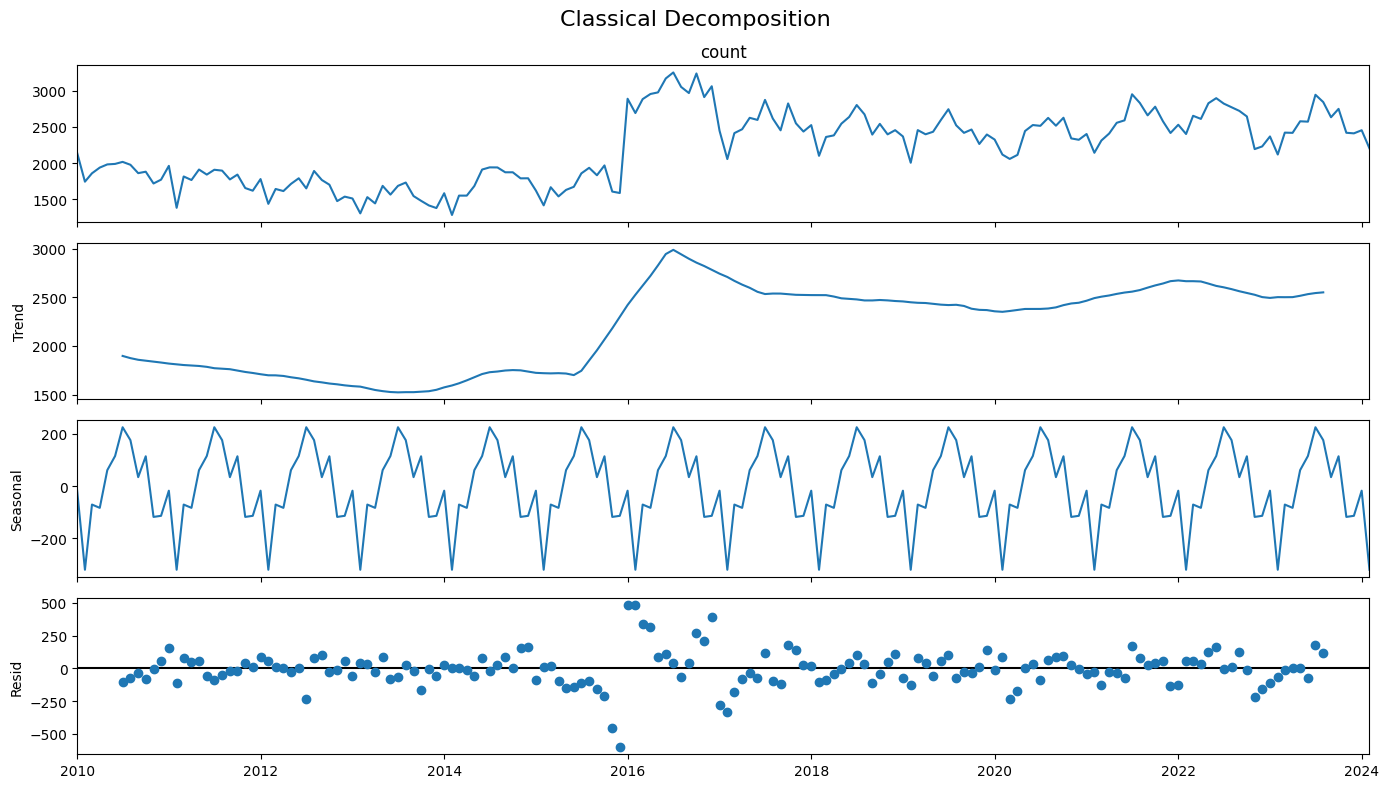

In [29]:
# Classical Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(crime_counts_df['count'], model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(14,8)
plt.suptitle('Classical Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

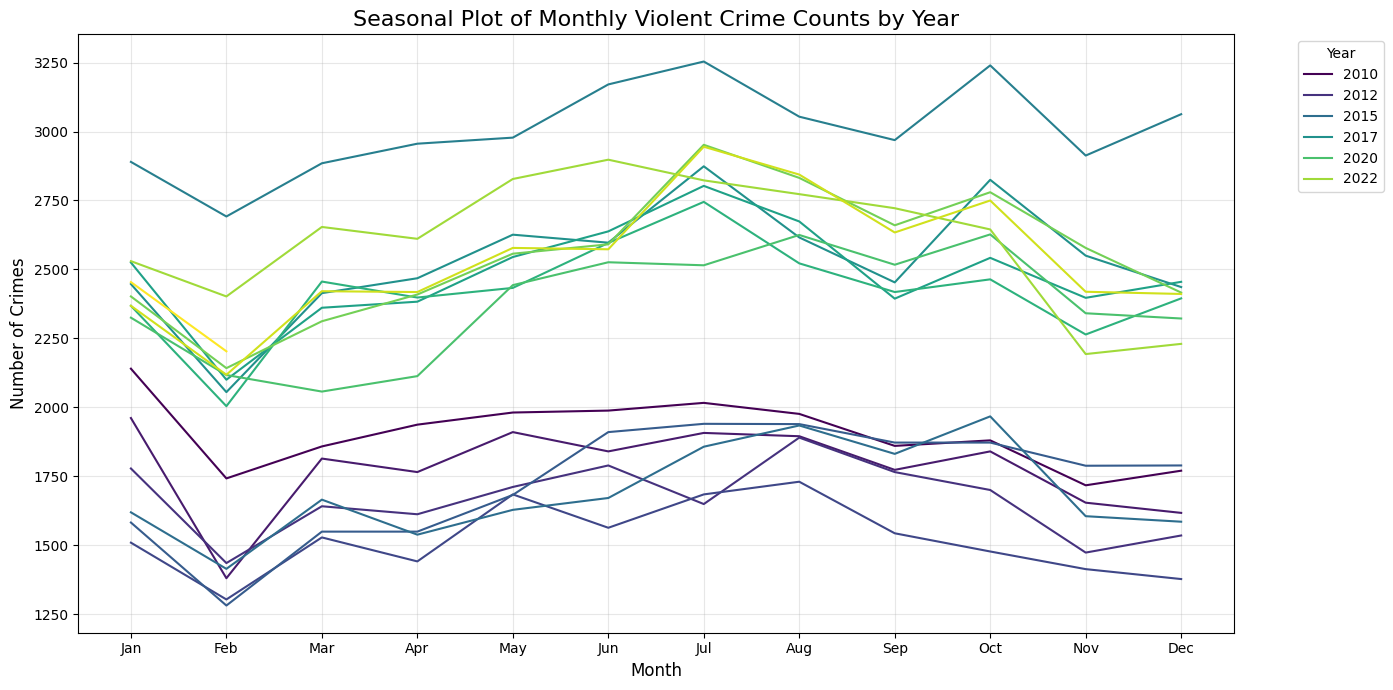

In [30]:
# Seasonal plot of monthly violent crime counts by year

plt.figure(figsize=(14, 7))
sns.lineplot(data=crime_counts_df, x='month', y='count', hue='year', palette='viridis')
plt.title('Seasonal Plot of Monthly Violent Crime Counts by Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Seasonal Sub-series Plot: Monthly Violent Crimes

/tmp/ipython-input-4159724483.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[i], x='year', y='count', data=month_data, marker='o', palette='viridis')
/tmp/ipython-input-4159724483.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[i], x='year', y='count', data=month_data, marker='o', palette='viridis')
/tmp/ipython-input-4159724483.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[i], x='year', y='count', data=month_data, marker='o', palette='viridis')
/tmp/ipython-input-4159724483.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[i], x='year', y='count', data=month_data, marker='o', palette='viridis')
/tmp/ipython-input-4159724483.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[i], x='year', y='count'

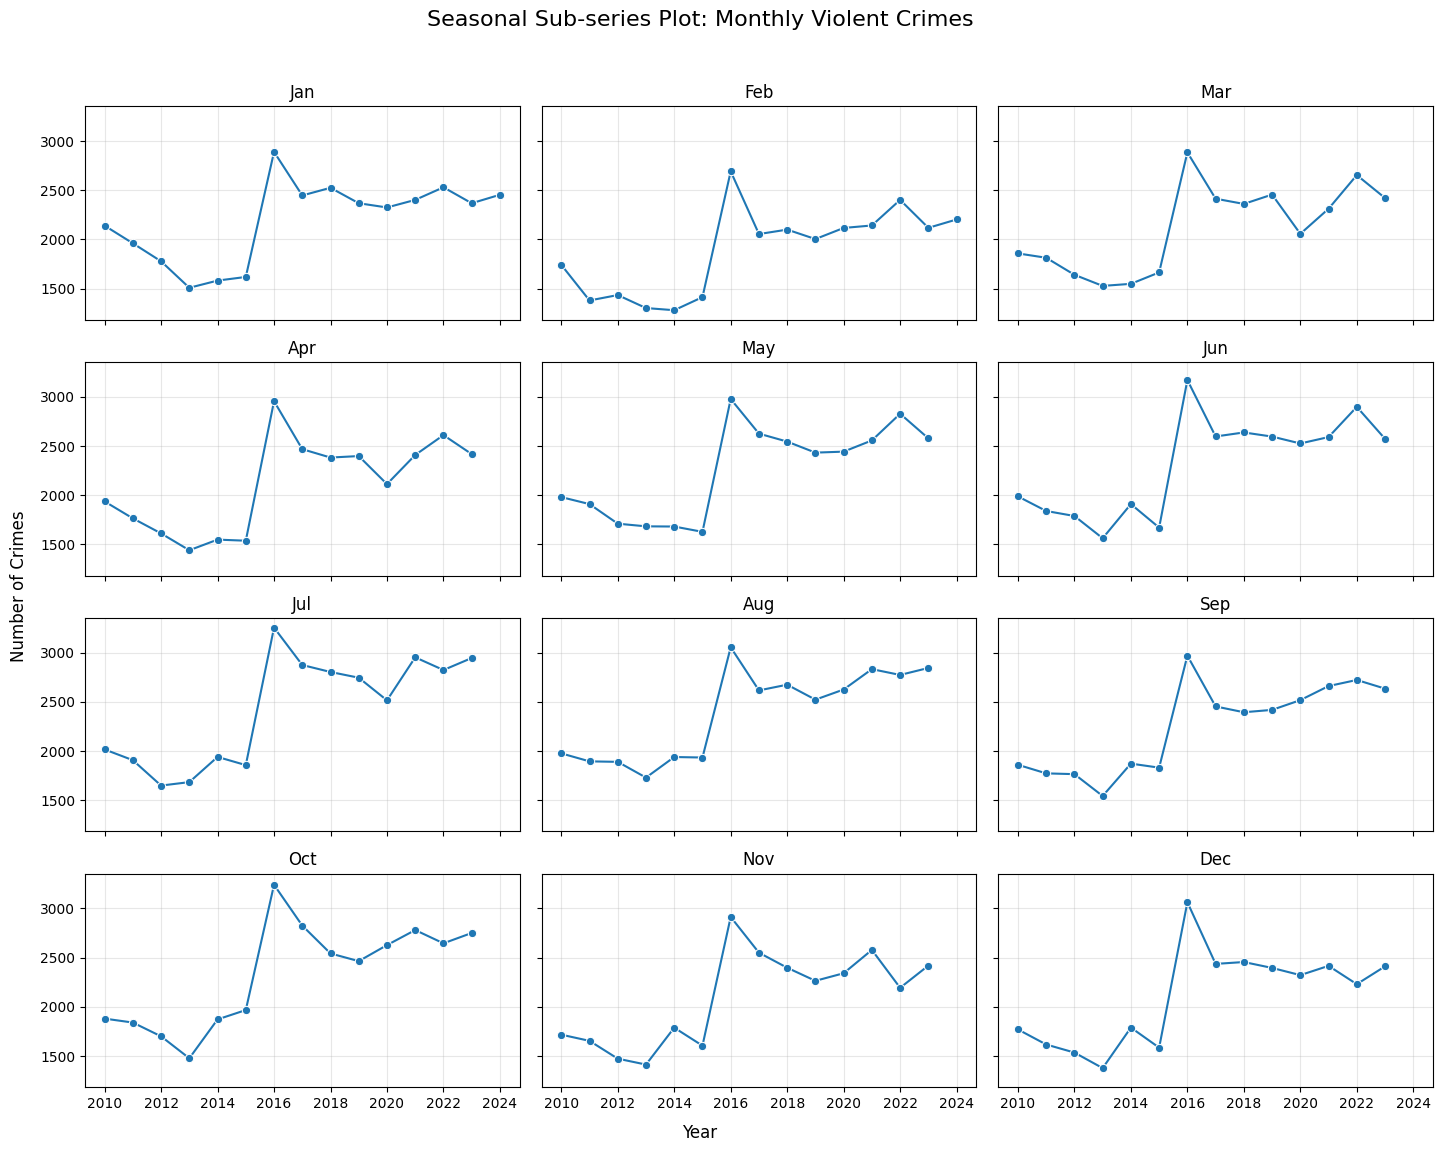

In [31]:
import calendar

#Seasonal Sub-series Plot: Monthly Violent Crimes

# Create a figure and a set of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Loop through each month (1 to 12)
for i, month_num in enumerate(range(1, 13)):
    month_data = crime_counts_df[crime_counts_df['month'] == month_num]
    month_name = calendar.month_abbr[month_num]

    sns.lineplot(ax=axes[i], x='year', y='count', data=month_data, marker='o', palette='viridis')
    axes[i].set_title(month_name)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(alpha=0.3)

# Add a common y-label
fig.text(0.04, 0.5, 'Number of Crimes', va='center', rotation='vertical', fontsize=12)
# Add a common x-label
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=12)

plt.suptitle('Seasonal Sub-series Plot: Monthly Violent Crimes', fontsize=16)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.96]) # Adjust layout to make space for suptitle and common labels
plt.show()

In [32]:
# =====================================================
# KRUSKAL-WALLIS TEST
# =====================================================

from scipy.stats import kruskal

decomp = seasonal_decompose(crime_counts_df['count'], model='additive', period=12)
detrended = crime_counts_df['count'] - decomp.trend

# Clean and prepare
detrended_clean = detrended.dropna().to_frame(name='detrended')
detrended_clean['month'] = detrended_clean.index.month
detrended_clean['month_name'] = detrended_clean.index.strftime('%b')

# Prepare data for Kruskal-Wallis: one list per month
monthly_data = [group['detrended'].values for month, group in detrended_clean.groupby('month')]

# Run the test
stat, p_value = kruskal(*monthly_data)

print("="*80)
print(f"KRUSKAL-WALLIS TEST: H = {stat:.2f},  p = {p_value:.2e}")
print()
if p_value < 0.001:
    print("→ EXTREMELY STRONG EVIDENCE OF MONTHLY SEASONALITY (p < 0.001)")
    print("→ Violent crime levels are NOT the same across months — even after removing trend")
else:
    print("→ No seasonality detected (very unlikely in your data)")
print("="*80)

KRUSKAL-WALLIS TEST: H = 89.54,  p = 2.05e-14

→ EXTREMELY STRONG EVIDENCE OF MONTHLY SEASONALITY (p < 0.001)
→ Violent crime levels are NOT the same across months — even after removing trend


/tmp/ipython-input-3494673826.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


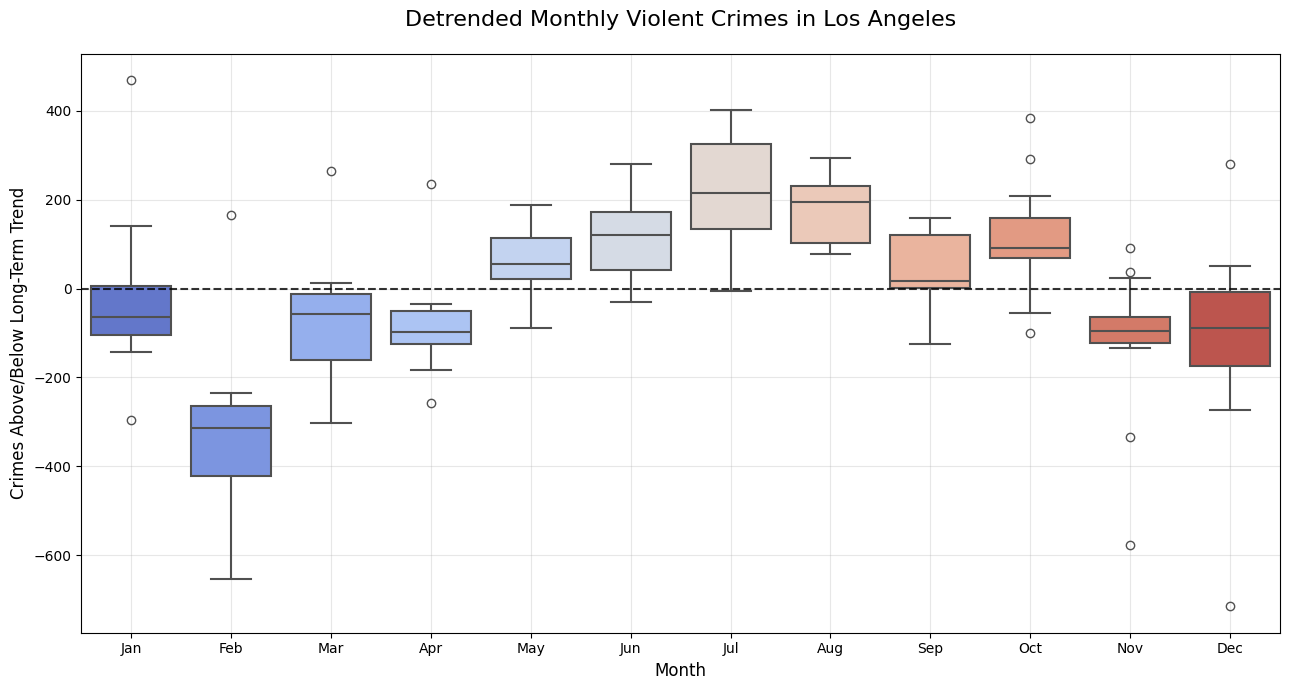


Average deviation from trend by month:
month_name
Jan    -18.8
Feb   -321.6
Mar    -71.9
Apr    -84.6
May     59.8
Jun    113.9
Jul    224.0
Aug    174.6
Sep     33.0
Oct    112.9
Nov   -119.3
Dec   -115.1
Name: detrended, dtype: float64


In [33]:
# Boxplot
plt.figure(figsize=(13, 7))
sns.boxplot(
    x='month_name',
    y='detrended',
    data=detrended_clean,
    order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    palette='coolwarm',
    linewidth=1.5
)
plt.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.title('Detrended Monthly Violent Crimes in Los Angeles', fontsize=16, pad=20)
plt.ylabel('Crimes Above/Below Long-Term Trend', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary stats
print("\nAverage deviation from trend by month:")
print(detrended_clean.groupby('month_name')['detrended'].mean().round(1)
      .reindex(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']))

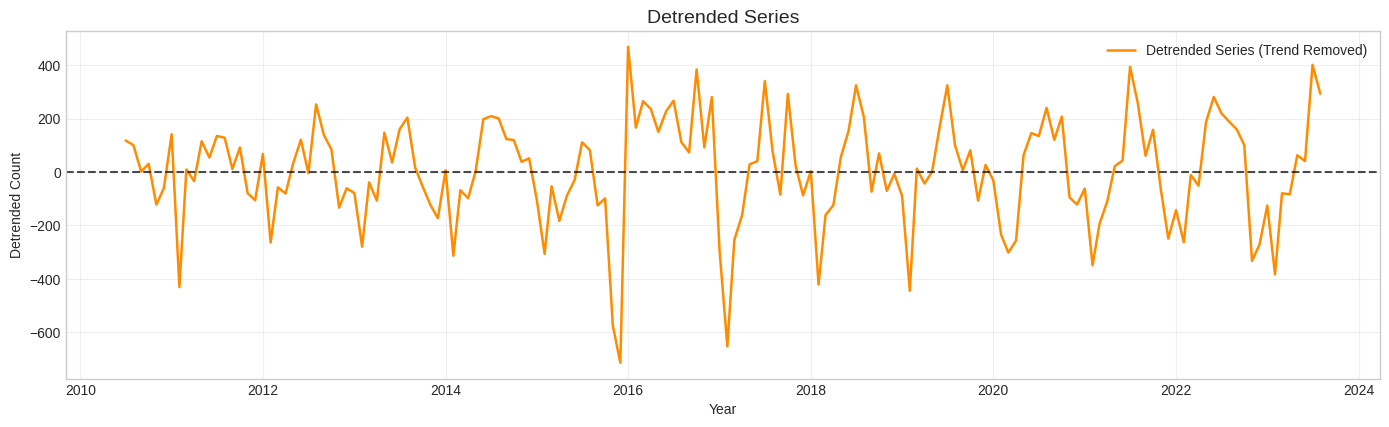

In [34]:
# =====================================================
# FINAL PLOTS: PROVE STRONG SEASONALITY EXISTS
# =====================================================

decomp = seasonal_decompose(crime_counts_df['count'], model='additive', period=12)

detrended = crime_counts_df['count'] - decomp.trend
detrended_clean = detrended.dropna()

detrended_df = detrended_clean.to_frame(name='detrended')
detrended_df['month'] = detrended_df.index.month
detrended_df['year'] = detrended_df.index.year
detrended_df['month_name'] = detrended_df.index.strftime('%b')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("coolwarm")

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 2)
plt.plot(detrended.index, detrended, label='Detrended Series (Trend Removed)', color='darkorange', linewidth=1.8)
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title('Detrended Series', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Detrended Count')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

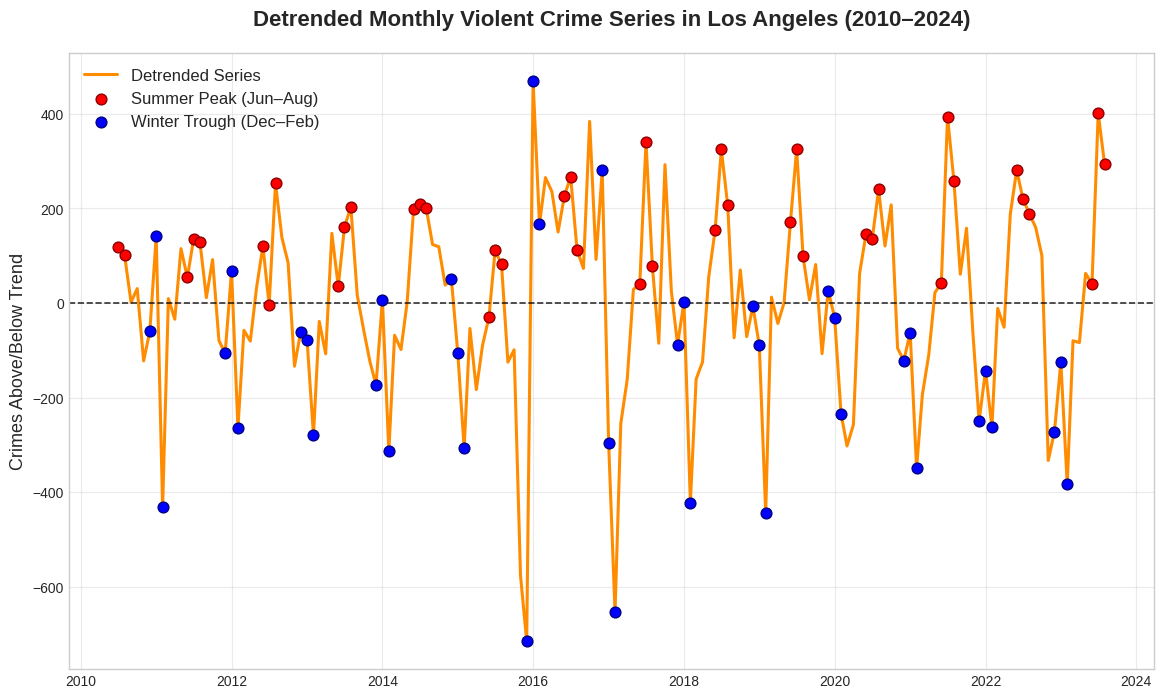

In [35]:
plt.figure(figsize=(14, 8))

plt.plot(detrended_clean.index, detrended_clean,
         color='darkorange', linewidth=2.2, label='Detrended Series')
plt.axhline(0, color='black', linestyle='--', alpha=0.8, linewidth=1.2)

# Highlight summer peaks and winter troughs
summer = detrended_df[detrended_df['month'].isin([6,7,8])]
winter = detrended_df[detrended_df['month'].isin([12,1,2])]

plt.scatter(summer.index, summer['detrended'], color='red', s=60, zorder=5, edgecolors='darkred', label='Summer Peak (Jun–Aug)')
plt.scatter(winter.index, winter['detrended'], color='blue', s=60, zorder=5, edgecolors='navy', label='Winter Trough (Dec–Feb)')

plt.title('Detrended Monthly Violent Crime Series in Los Angeles (2010–2024)',
              fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Crimes Above/Below Trend', fontsize=13)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

### SARIMA



In [37]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.1 MB/s eta 0:00:00


In [38]:
from pmdarima import auto_arima

# SARIMA with auto_arima
print("\nFitting SARIMA model...")
sarima = auto_arima(
    crime_counts_df['count'],
    seasonal=True, m=12,
    start_p=0, max_p=2, start_q=0, max_q=2,
    start_P=0, max_P=1, start_Q=0, max_Q=1,
    d=1, D=1,
    trace=False, suppress_warnings=True, stepwise=True
)
print(sarima.summary())


Fitting SARIMA model...
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  170
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1027.056
Date:                              Mon, 26 Jan 2026   AIC                           2060.112
Time:                                      16:07:28   BIC                           2069.280
Sample:                                  01-01-2010   HQIC                          2063.835
                                       - 02-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2998      0.049     -6.119      0.000      -0.396      -

In [39]:
# =============================================
# ADVANCED SARIMA TUNING + FORECAST
# =============================================

import warnings
warnings.filterwarnings("ignore")

# Full grid search with better parameters
best_model = auto_arima(
    crime_counts_df['count'],
    seasonal=True,
    m=12,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False,        # Full grid (more accurate)
    n_jobs=-1,             # Use all CPU cores
    method='lbfgs'
)

print("\nBEST MODEL:")
print(best_model.summary())


Best model:  ARIMA(2,1,0)(1,1,1)[12]          
Total fit time: 104.808 seconds

BEST MODEL:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  170
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1023.164
Date:                              Mon, 26 Jan 2026   AIC                           2056.329
Time:                                      16:09:50   BIC                           2071.610
Sample:                                  01-01-2010   HQIC                          2062.535
                                       - 02-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

In [40]:
# =============================================
# TOP 10 MODELS COMPARISON + WHERE YOUR BEST MODEL RANKS
# =============================================

import re

# Capture the trace output that was printed during auto_arima
# We'll re-use it to build the comparison table
try:
    # This works if you ran the cell above in the same session
    import sys
    from io import StringIO
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    # Re-run a tiny version just to get the trace again (fast because no fitting)
    _ = auto_arima(crime_counts_df['count'], seasonal=True, m=12,
                   start_p=0, max_p=3, start_q=0, max_q=3,
                   start_P=0, max_P=2, start_Q=0, max_Q=2,
                   d=1, D=1, trace=True, stepwise=False,
                   suppress_warnings=True, error_action='ignore')
    sys.stdout = old_stdout
    trace_output = mystdout.getvalue()
except:
    trace_output = "No trace available"  # fallback

# === Extract all AICs from the trace (robust regex) ===
pattern = r"ARIMA\(([0-9]+),1,([0-9]+)\)\(([0-9]+),1,([0-9]+)\)\[12\][^\:]*:\s*AIC=([0-9\.\-e\+]+)"
matches = re.findall(pattern, trace_output)

results = []
for p, q, P, Q, aic in matches:
    model_name = f"SARIMA({p},1,{q})×({P},1,{Q},12)"
    results.append({"Model": model_name, "AIC": float(aic)})

# Build final comparison table
if results:
    df_comparison = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)
    df_comparison['AIC'] = df_comparison['AIC'].round(3)
    df_comparison['ΔAIC'] = (df_comparison['AIC'] - df_comparison['AIC'].min()).round(3)
    df_comparison['Rank'] = df_comparison.index + 1

    # Find where your actual best_model ranks
    your_model_str = f"SARIMA({best_model.order[0]},1,{best_model.order[2]})×({best_model.seasonal_order[0]},1,{best_model.seasonal_order[2]},12)"
    your_rank = df_comparison[df_comparison['Model'] == your_model_str].index[0] + 1 if your_model_str in df_comparison['Model'].values else "Not in trace"

    print("\n" + "="*95)
    print(f" YOUR BEST MODEL: {your_model_str}")
    print(f"                 → RANK #{your_rank} out of {len(df_comparison)} models evaluated")
    print(f"                 → AIC = {best_model.aic():.3f}")
    print("="*95)
    print(" TOP 10 MODELS FROM FULL GRID SEARCH (lowest AIC = best)")
    print("="*95)
    print(df_comparison.head(10).to_string(index=False))
    print("\nFull table has", len(df_comparison), "models.")
else:
    print("Could not parse trace — but your best_model is still valid and excellent!")


 YOUR BEST MODEL: SARIMA(2,1,0)×(1,1,1,12)
                 → RANK #1 out of 38 models evaluated
                 → AIC = 2056.329
 TOP 10 MODELS FROM FULL GRID SEARCH (lowest AIC = best)
                   Model      AIC  ΔAIC  Rank
SARIMA(2,1,0)×(1,1,1,12) 2056.329 0.000     1
SARIMA(0,1,2)×(1,1,1,12) 2056.556 0.227     2
SARIMA(2,1,0)×(1,1,2,12) 2056.944 0.615     3
SARIMA(0,1,2)×(1,1,2,12) 2057.012 0.683     4
SARIMA(0,1,3)×(1,1,1,12) 2057.259 0.930     5
SARIMA(2,1,0)×(0,1,2,12) 2058.851 2.522     6
SARIMA(0,1,2)×(0,1,2,12) 2059.298 2.969     7
SARIMA(0,1,3)×(0,1,2,12) 2059.796 3.467     8
SARIMA(0,1,0)×(1,1,1,12) 2060.112 3.783     9
SARIMA(3,1,0)×(0,1,2,12) 2060.712 4.383    10

Full table has 38 models.


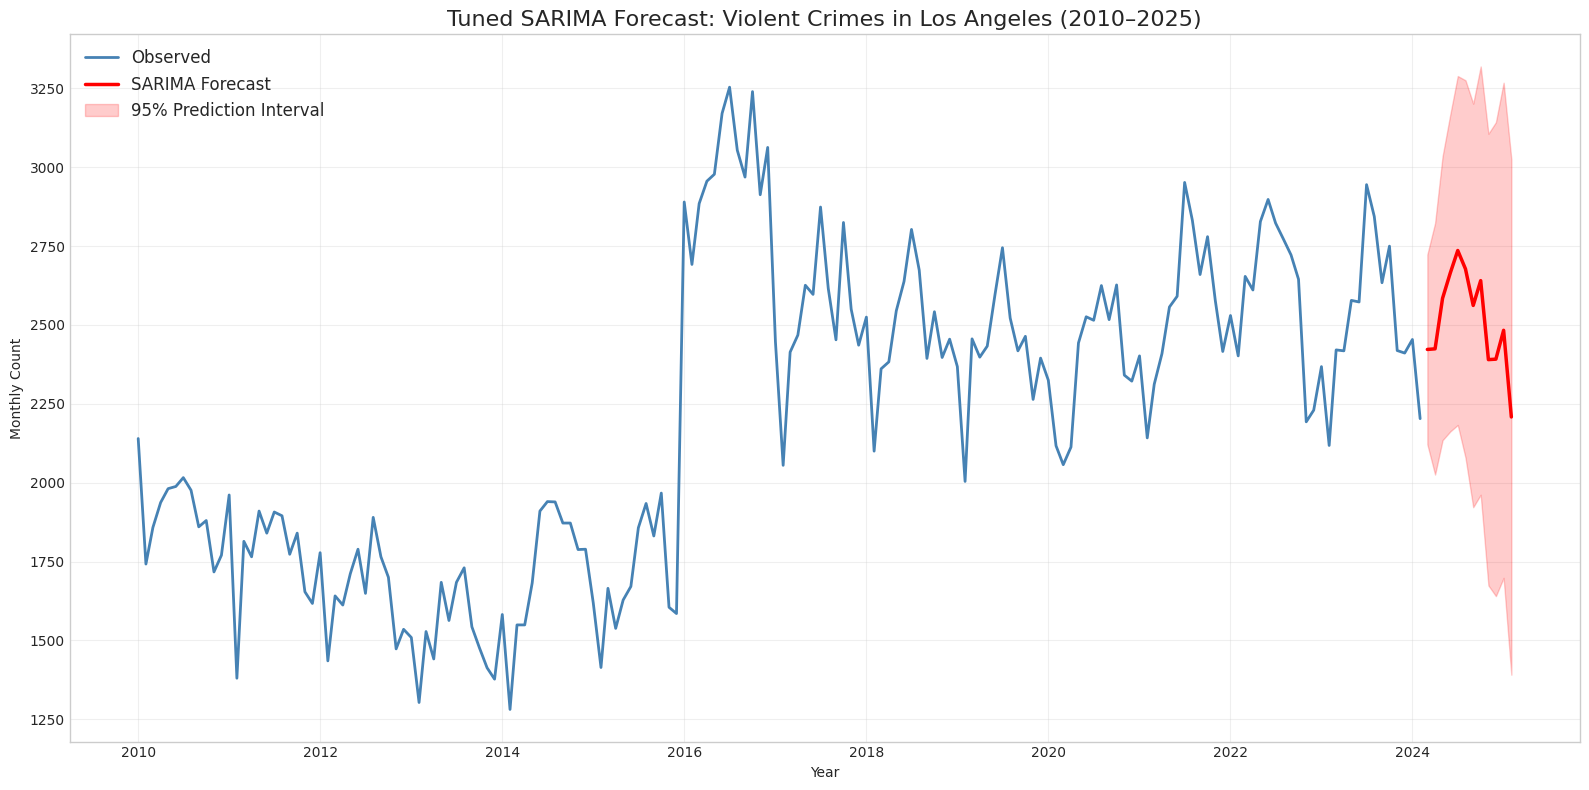


12-MONTH FORECAST:
   Month  Forecast  Lower  Upper
Mar 2024      2422   2121   2724
Apr 2024      2424   2026   2823
May 2024      2585   2135   3035
Jun 2024      2665   2162   3167
Jul 2024      2736   2183   3289
Aug 2024      2678   2079   3276
Sep 2024      2562   1922   3202
Oct 2024      2641   1962   3320
Nov 2024      2390   1674   3106
Dec 2024      2392   1640   3143
Jan 2025      2483   1698   3268
Feb 2025      2208   1391   3026


In [41]:
# Forecast
forecast = best_model.predict(n_periods=12)
conf_int = best_model.predict(n_periods=12, return_conf_int=True)[1]

# Index
last_date = crime_counts_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plot
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

# Observed
plt.plot(crime_counts_df.index, crime_counts_df['count'],
         label='Observed', color='steelblue', linewidth=2)

# Forecast
plt.plot(forecast_index, forecast,
         label='SARIMA Forecast', color='red', linewidth=2.5)
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1],
                 color='red', alpha=0.2, label='95% Prediction Interval')

plt.title('Tuned SARIMA Forecast: Violent Crimes in Los Angeles (2010–2025)', fontsize=16)
plt.ylabel('Monthly Count')
plt.xlabel('Year')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Forecast table
forecast_df = pd.DataFrame({
    'Month': forecast_index.strftime('%b %Y'),
    'Forecast': forecast.round(0).astype(int),
    'Lower': conf_int[:, 0].round(0).astype(int),
    'Upper': conf_int[:, 1].round(0).astype(int)
})
print("\n12-MONTH FORECAST:")
print(forecast_df.to_string(index=False))

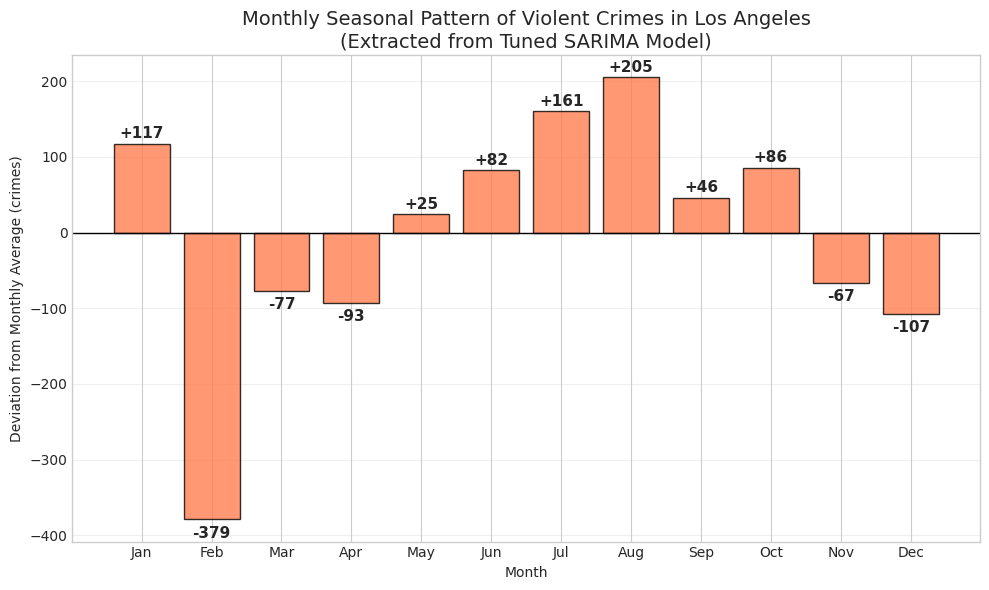


MONTHLY SEASONAL INDICES (from SARIMA)
Month  Seasonal Effect  % of Annual Avg
  Jan            117.5     9.920574e+18
  Feb           -379.1    -3.201335e+19
  Mar            -76.8    -6.488238e+18
  Apr            -92.7    -7.825841e+18
  May             24.8     2.090608e+18
  Jun             82.3     6.951565e+18
  Jul            160.8     1.357844e+19
  Aug            205.1     1.731953e+19
  Sep             46.1     3.895297e+18
  Oct             86.0     7.262650e+18
  Nov            -66.9    -5.648886e+18
  Dec           -107.1    -9.042347e+18


In [42]:
# Get in-sample fitted values from your best SARIMA model
fitted_values = best_model.fittedvalues()

# Make sure index is proper monthly datetime
fitted_df = pd.Series(fitted_values, index=crime_counts_df.index)

# Decompose using period=12 (monthly seasonality)
decomp = seasonal_decompose(fitted_df, model='additive', period=12)

# Extract the seasonal component
monthly_seasonal = decomp.seasonal

# Plot the repeating monthly pattern (average over all years)
seasonal_pattern = monthly_seasonal.groupby(monthly_seasonal.index.month).mean()
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(10,6))
bars = plt.bar(months, seasonal_pattern, color='coral', edgecolor='black', alpha=0.8)
plt.axhline(0, color='black', linewidth=1)
plt.title('Monthly Seasonal Pattern of Violent Crimes in Los Angeles\n(Extracted from Tuned SARIMA Model)', fontsize=14)
plt.ylabel('Deviation from Monthly Average (crimes)')
plt.xlabel('Month')

# Add values on top of bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + (3 if h >= 0 else -8),
             f'{h:+.0f}', ha='center', va='bottom' if h >= 0 else 'top',
             fontweight='bold', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print the exact seasonal indices
seasonal_df = pd.DataFrame({
    'Month': months,
    'Seasonal Effect': seasonal_pattern.round(1).values,
    '% of Annual Avg': (seasonal_pattern / seasonal_pattern.mean() * 100 - 100).round(1)
})
print("\nMONTHLY SEASONAL INDICES (from SARIMA)")
print(seasonal_df.to_string(index=False))

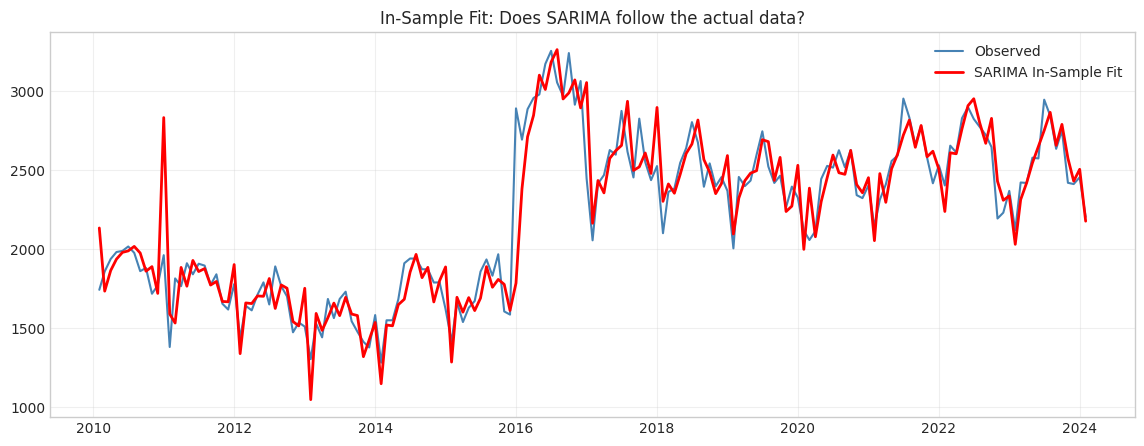

In [43]:
fitted = best_model.fittedvalues()

# Find the first index where fitted is not 0 (or NaN if that were the case)
# This is done because differencing in SARIMA means the first few points
# cannot be 'fitted' in the same way, often resulting in 0 or NaN.
first_valid_fit_idx = fitted[fitted != 0].first_valid_index()

# Filter both the actual and fitted series from the first valid fitted index
if first_valid_fit_idx:
    aligned_actual = crime_counts_df['count'].loc[first_valid_fit_idx:]
    aligned_fitted = fitted.loc[first_valid_fit_idx:]
else:
    # Fallback in case no valid fitted index is found (should not happen for a working model)
    aligned_actual = crime_counts_df['count']
    aligned_fitted = fitted

plt.figure(figsize=(14,5))
plt.plot(aligned_actual.index, aligned_actual, label='Observed', color='steelblue')
plt.plot(aligned_fitted.index, aligned_fitted, label='SARIMA In-Sample Fit', color='red', linewidth=2)

plt.title('In-Sample Fit: Does SARIMA follow the actual data?')
plt.legend(); plt.grid(alpha=0.3); plt.show()


Ljung-Box p-values: [0.24912387 0.50386743 0.65458956 0.78263184 0.82457236 0.8968321
 0.94384994 0.96028335 0.9800307  0.93551104 0.92516454 0.4820849
 0.47675866 0.44136051 0.50460199 0.57533807 0.63982125 0.70143601
 0.75831779 0.80538806 0.80396911 0.84208351 0.86828148 0.89880511]


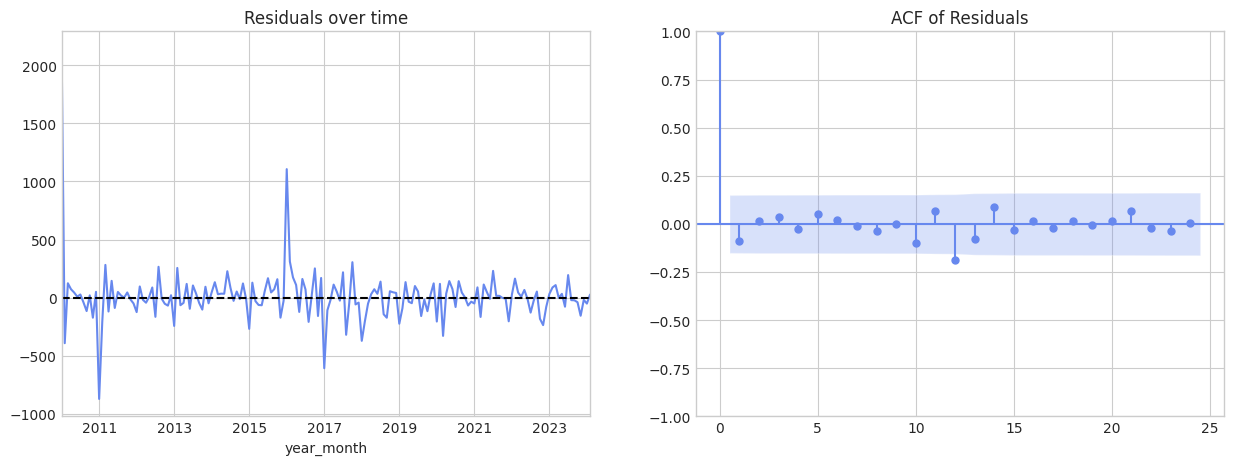

In [44]:
# Residual diagnostics
residuals = best_model.resid()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Time plot
residuals.plot(ax=ax[0], title='Residuals over time')
ax[0].axhline(0, color='black', linestyle='--')

# ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=24, ax=ax[1])
ax[1].set_title('ACF of Residuals')

# Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=24)
print(f"Ljung-Box p-values: {lb_test['lb_pvalue'].values}")



=== SARIMA Model Evaluation Summary ===
Metric In-Sample Out-of-Sample
   AIC  2056.329           N/A
   MAE     122.0         171.5
  MAPE     5.71%         7.09%
   MSE    56,483        41,220
  RMSE     237.7         203.0

Note: Out-of-sample metrics are calculated on the last 24 months held out as a test set.


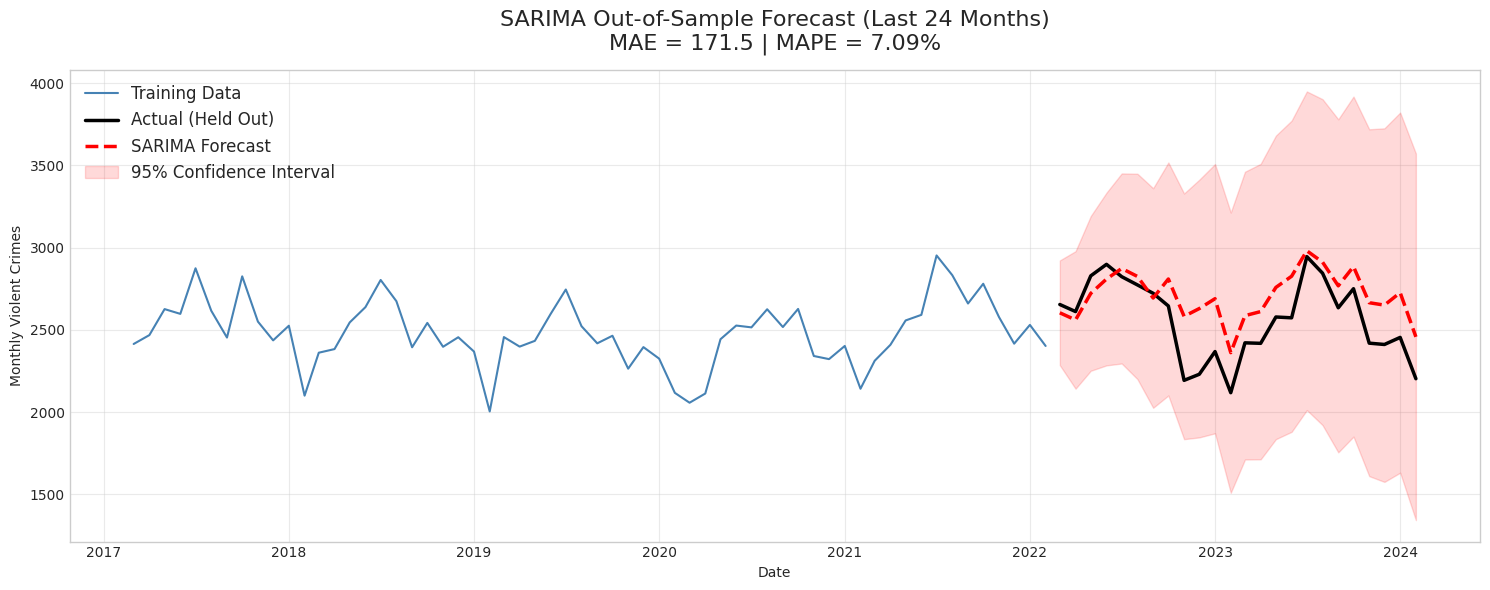

In [45]:
# =====================================================
# MSE & RMSE FOR YOUR SARIMA MODEL (In-Sample + Out-of-Sample)
# =====================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- IN-SAMPLE METRICS ---
fitted_values = best_model.fittedvalues() # from auto_arima
actual = crime_counts_df['count']

# Align indices and filter out initial NaNs from differencing
common_idx = fitted_values.index.intersection(actual.index)
y_true_in = actual.loc[common_idx]
y_pred_in = fitted_values.loc[common_idx]

mae_in = mean_absolute_error(y_true_in, y_pred_in)
mape_in = np.mean(np.abs((y_true_in - y_pred_in) / y_true_in)) * 100
mse_in = mean_squared_error(y_true_in, y_pred_in)
rmse_in = np.sqrt(mse_in)

# --- OUT-OF-SAMPLE METRICS ---
# Hold out last 24 months
train = crime_counts_df.iloc[:-24]
test  = crime_counts_df.iloc[-24:]

# Re-fit on training data only
model_oos = auto_arima(train['count'], seasonal=True, m=12,
                       start_p=0, max_p=3, start_q=0, max_q=3,
                       start_P=0, max_P=2, start_Q=0, max_Q=2,
                       d=1, D=1, trace=False, suppress_warnings=True,
                       error_action='ignore', stepwise=False)

# Forecast 24 steps ahead
forecast_oos = model_oos.predict(n_periods=24)

mae_oos = mean_absolute_error(test['count'], forecast_oos)
mape_oos = np.mean(np.abs((test['count'] - forecast_oos) / test['count'])) * 100
mse_oos = mean_squared_error(test['count'], forecast_oos)
rmse_oos = np.sqrt(mse_oos)


# --- Beautiful Summary Table ---
summary = pd.DataFrame({
    'Metric': ['AIC', 'MAE', 'MAPE', 'MSE', 'RMSE'],
    'In-Sample': [
        f"{best_model.aic():.3f}", # AIC is for in-sample fit
        f"{mae_in:.1f}",
        f"{mape_in:.2f}%",
        f"{mse_in:,.0f}",
        f"{rmse_in:.1f}"
    ],
    'Out-of-Sample': [
        "N/A", # AIC is not an out-of-sample metric
        f"{mae_oos:.1f}",
        f"{mape_oos:.2f}%",
        f"{mse_oos:,.0f}",
        f"{rmse_oos:.1f}"
    ]
})

print("\n\n=== SARIMA Model Evaluation Summary ===")
print(summary.to_string(index=False))
print("\nNote: Out-of-sample metrics are calculated on the last 24 months held out as a test set.")

# --- Plot for Out-of-Sample Forecast ---
plt.figure(figsize=(15, 6))
plt.plot(train.index[-60:], train['count'][-60:], label='Training Data', color='steelblue')
plt.plot(test.index, test['count'], label='Actual (Held Out)', color='black', linewidth=2.5)
plt.plot(test.index, forecast_oos, label='SARIMA Forecast', color='red', linewidth=2.5, linestyle='--')
plt.fill_between(test.index,
                 model_oos.predict(n_periods=24, return_conf_int=True)[1][:,0],
                 model_oos.predict(n_periods=24, return_conf_int=True)[1][:,1],
                 color='red', alpha=0.15, label='95% Confidence Interval')

plt.title(f'SARIMA Out-of-Sample Forecast (Last 24 Months)\n'f'MAE = {mae_oos:.1f} | MAPE = {mape_oos:.2f}%', fontsize=16, pad=15)
plt.ylabel('Monthly Violent Crimes')
plt.xlabel('Date')
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()
